Dataset Head:
  checking_status  duration                  credit_history  \
0              <0         6  critical/other existing credit   
1        0<=X<200        48                   existing paid   
2     no checking        12  critical/other existing credit   
3              <0        42                   existing paid   
4              <0        24              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv           1169  no known savings        >=7   
1             radio/tv           5951              <100     1<=X<4   
2            education           2096              <100     4<=X<7   
3  furniture/equipment           7882              <100     4<=X<7   
4              new car           4870              <100     1<=X<4   

   installment_commitment     personal_status other_parties  ...  \
0                       4         male single          none  ...   
1                       2  female div/dep/mar     

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Generating SHAP Summary Plot...


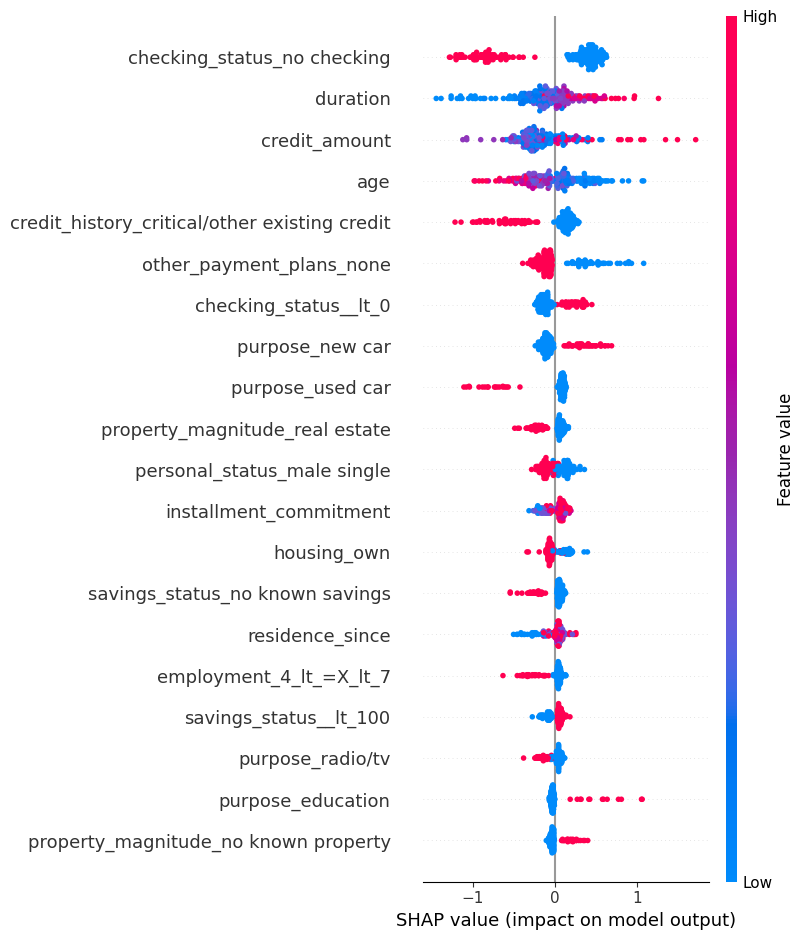

In [14]:
!pip install shap xgboost pandas scikit-learn matplotlib

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the Data
from sklearn.datasets import fetch_openml

print("Downloading dataset from OpenML... (this may take a few seconds)")
# This pulls the official 'credit-g' dataset
credit_data = fetch_openml(name='credit-g', version=1, parser='auto')
df = credit_data.frame

df.rename(columns={'class': 'Risk'}, inplace=True)

# Quick look at the data
print("Dataset Head:")
print(df.head())
print("\nColumns:", df.columns)

# Preprocessing
# The dataset has "text" categories (Sex, Housing, Purpose).
# Computers only understand numbers. We use "One-Hot Encoding" to fix this.
# Example: "Housing: Own" becomes a column "Housing_Own" with a 1 or 0.

# Check for missing values - fill them or drop them
df = df.dropna()

# Separate Target (Risk) from Features
# We need to map "Good" to 0 and "Bad" to 1 (Bad is usually the "positive" class we want to detect).
target_map = {'good': 0, 'bad': 1}
df['Risk'] = df['Risk'].map(target_map)

X = df.drop('Risk', axis=1) # Features
y = df['Risk']              # Target

# Convert categorical columns to numeric (One-Hot Encoding)
X = pd.get_dummies(X, drop_first=True)

# Fix for XBoost error
X.columns = X.columns.str.replace('<', '_lt_', regex=False)
X.columns = X.columns.str.replace('[', '_', regex=False)
X.columns = X.columns.str.replace(']', '_', regex=False)

# Split data into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Model (XGBoost)
# XGBoost is an industry standard for tabular data.
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# Evaluate
predictions = model.predict(X_test)
print(f"\nModel Accuracy: {accuracy_score(y_test, predictions) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Explainability with SHAP
# This explains WHY the model made specific decisions.
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Plot the summary
print("\nGenerating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test)

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       141
           1       0.67      0.49      0.57        59

    accuracy                           0.78       200
   macro avg       0.74      0.70      0.71       200
weighted avg       0.77      0.78      0.77       200



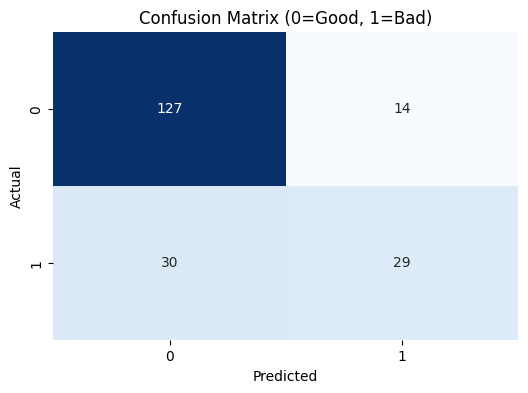

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(X_test)

# The Numbers
print(classification_report(y_test, predictions))

# The Visual (Confusion Matrix)
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (0=Good, 1=Bad)')
plt.show()

In [16]:
# Pick a random person from the test set to use as a template
# (We use .iloc[0] to get the first row, .copy() to ensure we don't change the original data)
new_applicant = X_test.iloc[0].copy()

# ---------------------------------------------------------
# 2. MODIFY THE DATA (Play with these values!)
# ---------------------------------------------------------
# Let's make this person look very risky:
new_applicant['duration'] = 60           # 60 month loan (Very long)
new_applicant['credit_amount'] = 15000   # Huge amount of money
new_applicant['age'] = 20                # Young
new_applicant['checking_status_no checking'] = 1 # No checking account (Major Red Flag)

# Or make them safe:
# new_applicant['duration'] = 12
# new_applicant['checking_status_no checking'] = 0
# ---------------------------------------------------------

# Format the data for the model
# The model expects a 2D array (a table), not a 1D list (a row), so we reshape it.
data_for_model = new_applicant.values.reshape(1, -1)

# Get the Prediction
prediction = model.predict(data_for_model)[0]
probability = model.predict_proba(data_for_model)[0]

# Display Result
print(f"Applicant Details:\nDuration: {new_applicant['duration']} months")
print(f"Amount: ${new_applicant['credit_amount']}")
print("-" * 30)

if prediction == 1:
    print(f"🔴 PREDICTION: HIGH RISK (Bad Credit)")
    print(f"Confidence: {probability[1]*100:.2f}% sure they will default.")
else:
    print(f"🟢 PREDICTION: LOW RISK (Good Credit)")
    print(f"Confidence: {probability[0]*100:.2f}% sure they will pay it back.")

Applicant Details:
Duration: 60 months
Amount: $15000
------------------------------
🔴 PREDICTION: HIGH RISK (Bad Credit)
Confidence: 67.47% sure they will default.


--- Default Threshold (0.50) ---
Bad Loans Caught (Recall): 49.15%
Precision: 67.44%

--- New Threshold (0.3) ---
Bad Loans Caught (Recall): 66.10%
Precision: 52.00%


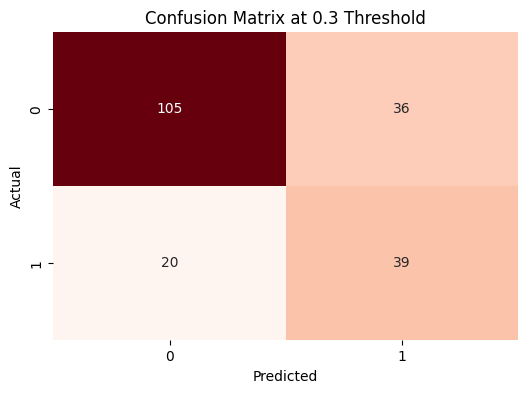

In [17]:
from sklearn.metrics import recall_score, precision_score

# Get the raw probabilities instead of just 0 or 1
# This gives us the % chance of "Risk" for every person
y_proba = model.predict_proba(X_test)[:, 1]

# Define your new "Strict" threshold
threshold = 0.30  # If risk probability > 30%, flag as Bad

# Create new predictions based on this threshold
y_pred_new = (y_proba > threshold).astype(int)

# Compare Results (The Business Case)
print(f"--- Default Threshold (0.50) ---")
print(f"Bad Loans Caught (Recall): {recall_score(y_test, predictions):.2%}")
print(f"Precision: {precision_score(y_test, predictions):.2%}")

print(f"\n--- New Threshold ({threshold}) ---")
print(f"Bad Loans Caught (Recall): {recall_score(y_test, y_pred_new):.2%}")
print(f"Precision: {precision_score(y_test, y_pred_new):.2%}")

# Visual Proof
plt.figure(figsize=(6, 4))
cm_new = confusion_matrix(y_test, y_pred_new)
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f'Confusion Matrix at {threshold} Threshold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

✅ OPTIMAL THRESHOLD FOUND: 0.13
💰 Minimum Business Cost: 101


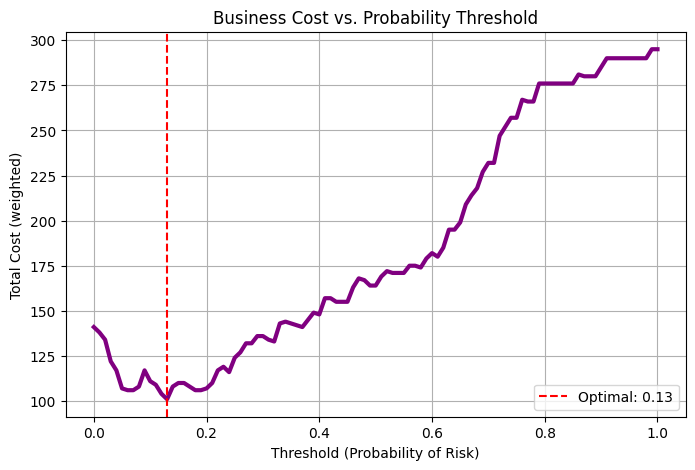

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define Business Costs
# Assumption: Losing the loan principal is 5x worse than missing out on interest.
COST_FN = 5  # Cost of letting a bad loan slip through (Default)
COST_FP = 1  # Cost of rejecting a good customer (Lost Opportunity)

# Prepare to search
thresholds = np.linspace(0, 1, 101) # Test 0.00, 0.01, 0.02 ... 1.00
costs = []

# The Automation Loop
y_proba = model.predict_proba(X_test)[:, 1]

for t in thresholds:
    # Make predictions at this specific threshold
    preds = (y_proba > t).astype(int)

    # Calculate Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # Calculate Total Cost
    # Total Cost = (Bad Loans Missed * 5) + (Good Customers Rejected * 1)
    total_cost = (fn * COST_FN) + (fp * COST_FP)
    costs.append(total_cost)

# Find the Winner
best_index = np.argmin(costs)
best_threshold = thresholds[best_index]
min_cost = costs[best_index]

print(f"✅ OPTIMAL THRESHOLD FOUND: {best_threshold:.2f}")
print(f"💰 Minimum Business Cost: {min_cost}")

# Visualize the "Cost Curve"
plt.figure(figsize=(8, 5))
plt.plot(thresholds, costs, color='purple', linewidth=3)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Optimal: {best_threshold:.2f}')
plt.title('Business Cost vs. Probability Threshold')
plt.xlabel('Threshold (Probability of Risk)')
plt.ylabel('Total Cost (weighted)')
plt.legend()
plt.grid(True)
plt.show()

--- Default Threshold (0.50) ---
Bad Loans Caught (Recall): 49.15%
Precision: 67.44%

--- New Threshold (0.13) ---
Bad Loans Caught (Recall): 89.83%
Precision: 42.74%


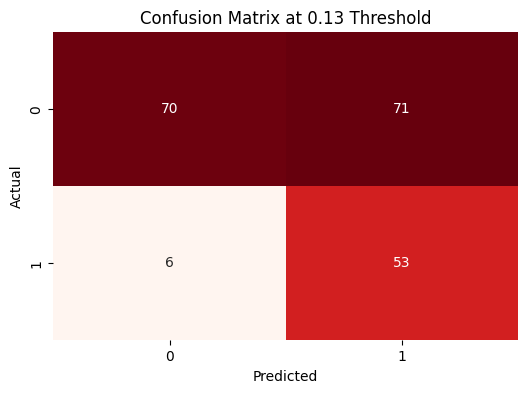

In [19]:
from sklearn.metrics import recall_score, precision_score

# Get the raw probabilities instead of just 0 or 1
# This gives us the % chance of "Risk" for every person
y_proba = model.predict_proba(X_test)[:, 1]

# Define your new "Strict" threshold
threshold = 0.13  # If risk probability > 30%, flag as Bad

# Create new predictions based on this threshold
y_pred_new = (y_proba > threshold).astype(int)

# Compare Results (The Business Case)
print(f"--- Default Threshold (0.50) ---")
print(f"Bad Loans Caught (Recall): {recall_score(y_test, predictions):.2%}")
print(f"Precision: {precision_score(y_test, predictions):.2%}")

print(f"\n--- New Threshold ({threshold}) ---")
print(f"Bad Loans Caught (Recall): {recall_score(y_test, y_pred_new):.2%}")
print(f"Precision: {precision_score(y_test, y_pred_new):.2%}")

# Visual Proof
plt.figure(figsize=(6, 4))
cm_new = confusion_matrix(y_test, y_pred_new)
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f'Confusion Matrix at {threshold} Threshold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

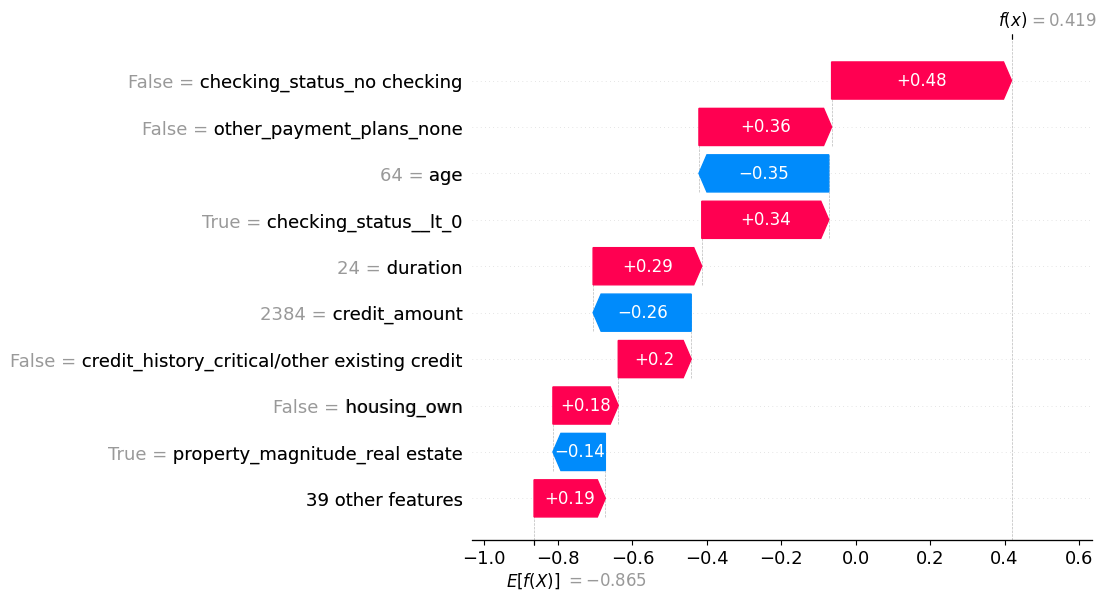

In [20]:
# Demonstration of Risk calculation for a single person
# Select one specific person (e.g., the 5th person in the test set)
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]

# Calculate SHAP values for just this one person
explainer = shap.Explainer(model)
shap_values_one = explainer(X_test.iloc[row_to_show:row_to_show+1])

# Generate the Waterfall Plot
# This shows exactly how we got from the Average to the Final Prediction
shap.plots.waterfall(shap_values_one[0])